## Results of Host Prediction
### Dataset: All viruses, all proteins, without duplicates (~19K)

**Model**: Logistic Regression

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1114

**Classification**: Multi-class

**\# classes**: 10

**\# train samples** = 14,633

**\# test samples** = 3,659

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve

In [3]:
output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce__lr_output.csv")

In [4]:
df = pd.read_csv(output_filepath, index_col=0)

In [5]:
df.shape

(18295, 11)

In [6]:
cols = df.columns
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))

In [7]:
non_human_cols

['Desert warthog',
 'Horse',
 'Lesser bandicoot rat',
 'Wood mouse',
 'Others',
 'Goat',
 'Cattle',
 'Red junglefowl']

In [8]:
itrs = df[itr_col].unique()
itrs

array([0, 1, 2, 3, 4])

In [9]:
def compute_auprc(df_itr, y_pred_columns, y_true_col):
    pr_curves = []
    auprcs = []
    for y_pred_column in y_pred_columns:
        precision, recall, _ = precision_recall_curve(y_true=df_itr[y_true_col].values, probas_pred=df_itr[y_pred_column].values, pos_label=y_pred_column)
        pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, "class": y_pred_column}))
        auprcs.append({"class": y_pred_column, "auprc": auc(recall, precision)})
    return pd.concat(pr_curves, ignore_index=True), pd.DataFrame(auprcs)

def compute_class_distribution(df, label_col, format=False):
    labels_counts = df[label_col].value_counts()
    n = labels_counts.sum()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k} ({v:.2f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [10]:
result = []
pr_curves = []
for itr in itrs:
    df_itr = df[df[itr_col] == itr]
    pr_curves_df, auprcs_df = compute_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
    pr_curves_df[itr_col] = itr
    auprcs_df[itr_col] = itr
    result.append(auprcs_df)
    pr_curves.append(pr_curves_df)

result_df = pd.concat(result, ignore_index=True)
pr_curves_df = pd.concat(pr_curves, ignore_index=True)
        

In [11]:
result_df.head(30)

,class,auprc,itr
0,Desert warthog,0.634923,0
1,Horse,0.641792,0
2,Lesser bandicoot rat,0.945001,0
3,Wood mouse,0.275750,0
4,Others,0.261668,0
5,Goat,0.448555,0
6,Cattle,0.109428,0
7,Red junglefowl,0.826922,0
8,Human,0.996359,0
9,Desert warthog,0.645417,1


In [12]:
pr_curves_df.head()

,precision,recall,class,itr
0,0.056300,1.0,Desert warthog,0
1,0.056315,1.0,Desert warthog,0
2,0.056330,1.0,Desert warthog,0
3,0.056346,1.0,Desert warthog,0
4,0.056361,1.0,Desert warthog,0


In [13]:
metadata = compute_class_distribution(df_itr, y_true_col, format=True)
metadata

{'Human': 'Human (79.20%)',
 'Desert warthog': 'Desert warthog (5.63%)',
 'Lesser bandicoot rat': 'Lesser bandicoot rat (4.18%)',
 'Others': 'Others (3.83%)',
 'Goat': 'Goat (2.30%)',
 'Red junglefowl': 'Red junglefowl (1.78%)',
 'Wood mouse': 'Wood mouse (1.48%)',
 'Cattle': 'Cattle (0.96%)',
 'Horse': 'Horse (0.66%)'}

#### AUPRC for each class

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Human (79.20%)'),
  Text(1, 0, 'Desert warthog (5.63%)'),
  Text(2, 0, 'Lesser bandicoot rat (4.18%)'),
  Text(3, 0, 'Others (3.83%)'),
  Text(4, 0, 'Goat (2.30%)'),
  Text(5, 0, 'Red junglefowl (1.78%)'),
  Text(6, 0, 'Wood mouse (1.48%)'),
  Text(7, 0, 'Cattle (0.96%)'),
  Text(8, 0, 'Horse (0.66%)')])

<Figure size 640x480 with 0 Axes>

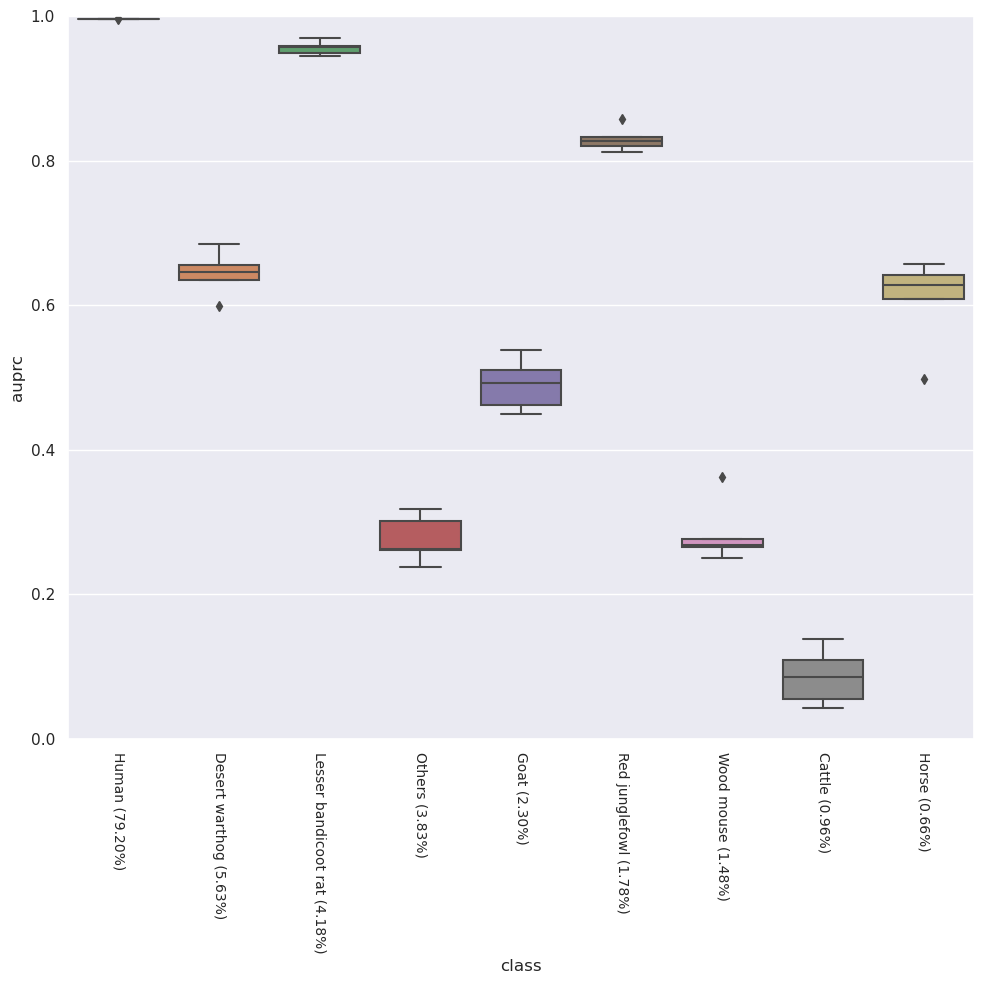

In [14]:
plt.clf()
sns.set_theme()

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['figure.autolayout'] = True
plt.figure(figsize=(10, 10))
ax = sns.boxplot(data=result_df, x="class", y="auprc", order=metadata.keys())
ax.set_ylim(0, 1)
ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
plt.tight_layout()
plt.xticks(rotation=-90)

#### Precision Recall Curves

/tmp/ipykernel_9435/27135650.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

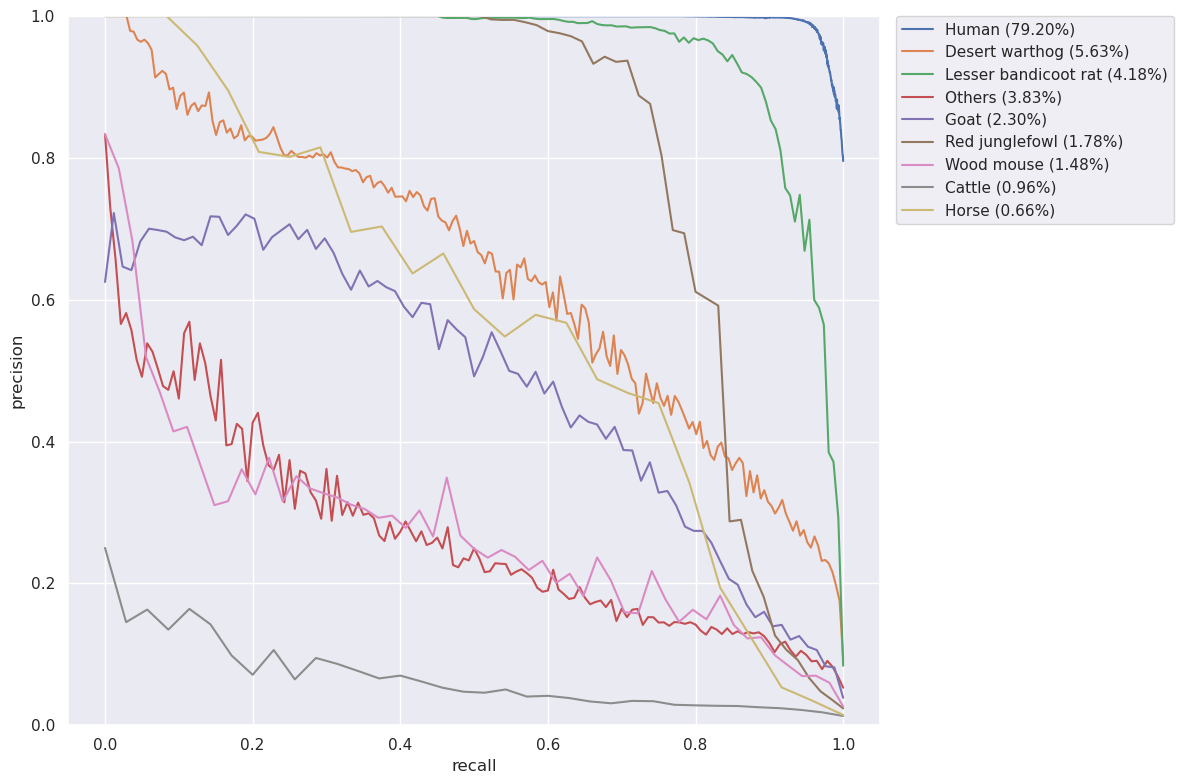

In [15]:
plt.clf()
sns.set_theme()
hue_order = None
if metadata is not None:
    pr_curves_df_metadata = pr_curves_df.replace({"class": metadata})
    hue_order = list(metadata.values())
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)

ax.set_ylim(0, 1)
plt.rcParams['xtick.labelsize'] = 8
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

### Class-wise prediction comparison

In [17]:
print(df.shape)
df.head()

(18295, 11)


,Cattle,Desert warthog,Goat,Horse,Human,Lesser bandicoot rat,Others,Red junglefowl,Wood mouse,y_true,itr
0,7.605815e-13,2.421802e-13,1.064136e-09,9.150042e-10,1.000000,8.149991e-10,3.394907e-08,3.727727e-10,2.413693e-19,Human,0
1,1.426648e-05,5.447373e-08,1.382506e-11,2.543766e-10,0.997420,1.260128e-11,2.565615e-03,8.762639e-08,4.185384e-17,Human,0
2,1.380493e-12,1.865424e-11,5.745906e-14,2.647738e-13,0.999010,1.229597e-19,9.896192e-04,2.122295e-09,1.951075e-23,Human,0
3,3.514560e-05,4.212037e-05,4.638045e-05,1.256303e-08,0.999720,7.893999e-11,1.499606e-04,6.790336e-06,9.024831e-14,Human,0
4,1.199373e-16,1.116431e-11,7.023025e-18,4.479320e-15,0.999891,8.317638e-21,1.092711e-04,2.275845e-07,1.400021e-24,Human,0


In [21]:
df["y_pred"] = df[list(metadata.keys())].idxmax(axis=1)

In [23]:
class_true_pred_count = []
for key in metadata.keys():
    class_true_pred_count.append({
        "class": key,
        "count": df[df["y_true"] == key].shape[0],
        "type": "y_true"
    })
    
    class_true_pred_count.append({
        "class": key,
        "count": df[df["y_pred"] == key].shape[0],
        "type": "y_pred"
    })

In [24]:
class_true_pred_count_df = pd.DataFrame(class_true_pred_count)

In [25]:
class_true_pred_count_df.head()

,class,count,type
0,Human,14490,y_true
1,Human,13480,y_pred
2,Desert warthog,1030,y_true
3,Desert warthog,1034,y_pred
4,Lesser bandicoot rat,765,y_true


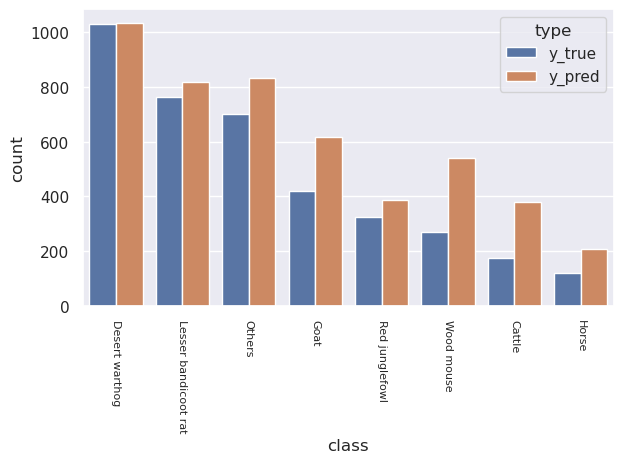

In [30]:
sns.barplot(class_true_pred_count_df[class_true_pred_count_df["class"] != "Human"], x="class", y="count", hue="type")
plt.xticks(rotation=-90)
plt.show()